# General information

...

## M/M/n queues for FIFO

In [10]:
# !pip install simpy

In [2]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Generator, List, Callable, Union, Tuple

### Functions for simulating a (Markovian) queue network

In [37]:
def interval_generator_markov(arrival_rate: float) -> float:
    """Generate a random number from the distribution of Markovian interarrival times.

    Specifically, returns a number sampled from an exponential distribution with parameter
    'arrival rate' = λ.

    Args:
        num_servers: Number of servers in the system (n).
        arrival_rate: The arrival rate of the system (λ).

    Returns:
        Random number sampled from an exponential distribution with parameter arrival rate.
    """
    return random.expovariate(arrival_rate)


def service_time_generator_markov(service_rate: float) -> float:
    """Generate a random number from the distribution of Markovian service times.

    Specifically, returns a number sampled from an exponential distribution with parameter
    'service rate' = μ.

    Args:
        service_rate: The service rate or capacity of each server (μ).

    Returns:
        Random number sampled from an exponential distribution with parameter service rate.
    """
    return random.expovariate(service_rate)


def markovian_client_process(
    env: simpy.Environment,
    resources: simpy.Resource,
    service_rate: float,
    wait_records: List[float],
) -> Generator[simpy.events.Event, None, None]:
    """Simulates a single client's process through the queue system, including waiting and service times.

    Specifically, samples service time from an exponential (markovian) distribution.

    Args:
        env: The SimPy environment managing simulation time.
        resources: The shared resource (e.g., servers) being accessed by the client.
        service_rate: The service rate or capacity of each server (μ).
        wait_records: A list to record the wait times of clients.

    Yields:
        Events representing the client's waiting and service times.
    """
    arrival_time = env.now
    with resources.request() as request:
        # Wait for resource availability
        yield request

        # Record the wait time
        wait_time = env.now - arrival_time
        wait_records.append(wait_time)

        # Simulate service time
        yield env.timeout(service_time_generator_markov(service_rate))


def request_spawner(
    env: simpy.Environment,
    resources: Union[simpy.Resource, simpy.PriorityResource],
    arrival_rate: float,
    service_rate: float,
    wait_records: List[float],
    client_process: Callable,
) -> Generator[simpy.events.Event, None, None]:
    """Continuously spawns client processes based on the interarrival time distribution.

    Args:
        env: The SimPy environment managing simulation time.
        resources: The shared resource (e.g., servers) being accessed by clients.
        num_servers: Number of servers in the system (n).
        arrival_rate: The arrival rate of the system (λ).
        service_rate: The service rate or capacity of each server (μ).
        wait_records: A list to record the wait times of clients.
        client_process: Function that calculates the process of a client through the system.

    Yields:
        Events representing client arrivals and process creation.
    """
    while True:
        yield env.timeout(interval_generator_markov(arrival_rate))
        env.process(
            client_process(env, resources, service_rate, wait_records)
        )


def simulate_queue_network(
    num_servers: int,
    arrival_rate: float,
    service_rate: float,
    sim_time: float,
    client_process: Callable = markovian_client_process,
    short_job_priority: bool = False,
) -> List[float]:
    """Simulates a queueing network with Markovian arrival and service processes.

    Args:
        num_servers: Number of servers in the system (n).
        arrival_rate: The arrival rate of the system (λ).
        service_rate: The service rate or capacity of each server (μ).
        sim_time: Total simulation time.
        client_process: Function that calculates the process of a client through the system.
            Defaults to process with markovian service time.
        short_job_priority: Scheduling type for queue network. SJP if True, FIFO else.

    Returns:
        A list of recorded wait times for all clients during the simulation.
    """
    # Calculate load factor (ρ) as λ / (n * μ)
    load_factor = arrival_rate / (num_servers * service_rate)
    if load_factor >= 1:
        raise ValueError("Load factor (ρ) must be less than 1 for a stable system.")

    # Set up simulation based on the job scheduling type
    env = simpy.Environment()
    if short_job_priority:
        resources = simpy.PriorityResource(env, capacity=num_servers)
    else:
        resources = simpy.Resource(env, capacity=num_servers)

    # Spawn clients and record their waiting time
    wait_records: List[float] = []
    env.process(
        request_spawner(
            env, resources, arrival_rate, service_rate, wait_records, client_process
        )
    )

    # Run the simulation
    env.run(until=sim_time)

    return wait_records

### Helper functions for comparing queue networks with different load factors

In [43]:
def run_simulations(
    load_factors: List[float],
    runs_per_config: int,
    servers_count: int,
    service_rate: float,
    simulation_time: int,
    client_process: Callable = markovian_client_process,
) -> pd.DataFrame:
    """Run multiple simulations for a queueing network under various configurations.

    Specifically, runs M/M/n FIFO by default.

    Args:
        load_factors: A list of load factors (ρ) to simulate.
        runs_per_config: The number of iterations to run for each load factor.
        servers_count: The number of servers in the queueing network.
        service_rate: The rate at which each server processes requests.
        simulation_time: The total time for each simulation run.
        client_process: Function that calculates the process of a client through the system.
            Defaults to process with markovian service time.

    Returns:
        A pandas DataFrame containing the simulation results with columns:
            - "Load Factor": The load factor (ρ) used in the simulation.
            - "Servers": The number of servers in the system.
            - "Customers": The number of customers considered.
            - "Iteration": The simulation iteration number.
            - "Mean Wait Time": The average waiting time for the given number of customers.
    """
    # Using a dictionary for results storage
    results_dict = {
        "Load Factor": [],
        "Servers": [],
        "Customers": [],
        "Iteration": [],
        "Mean Wait Time": [],
    }

    # Simulations with progress bars
    for load_factor in tqdm(load_factors, desc="Running simulations for different load factors"):
        arrival_rate = load_factor * servers_count * service_rate
        for iteration in tqdm(
            range(runs_per_config), leave=False, desc=f"Simulating for ρ={load_factor:.2f}"
        ):
            recorded_waits = simulate_queue_network(
                servers_count, arrival_rate, service_rate, simulation_time, client_process
            )
            customer_counts = np.arange(10, 10000, 500)
            for count in customer_counts:
                average_wait = np.mean(recorded_waits[:count])
                results_dict["Load Factor"].append(load_factor)
                results_dict["Servers"].append(servers_count)
                results_dict["Customers"].append(count)
                results_dict["Iteration"].append(iteration)
                results_dict["Mean Wait Time"].append(average_wait)

    # Convert the dictionary to a DataFrame
    results_df = pd.DataFrame(results_dict)
    return results_df


def plot_simulations(results_df: pd.DataFrame, load_factors: List[float]) -> None:
    """Plot the average waiting time as a function of the number of customers.

    Args:
        results_df: A pandas DataFrame containing simulation results, including:
            - "Load Factor": The load factor (ρ) used in the simulation.
            - "Customers": The number of customers considered.
            - "Mean Wait Time": The average waiting time for the given number of customers.
        load_factors: A list of load factors (ρ) to include in the plot.

    Returns:
        None. Displays a plot showing the relationship between the number of customers
        and the average waiting time for each load factor.
    """
    # Plotting the results
    plt.figure(figsize=(8, 6))
    for load_factor in load_factors:
        subset = results_df[results_df["Load Factor"] == load_factor]
        avg_waits = subset.groupby("Customers")["Mean Wait Time"].mean()
        plt.plot(avg_waits.index, avg_waits.values, label=f"ρ={load_factor}")

    plt.title("Average Waiting Time vs Number of Customers")
    plt.xlabel("Number of Customers")
    plt.ylabel("Average Waiting Time")
    plt.legend()
    plt.grid(True)
    plt.show()

### M/M/1

Running simulations for different load factors: 100%|██████████| 5/5 [00:27<00:00,  5.50s/it]


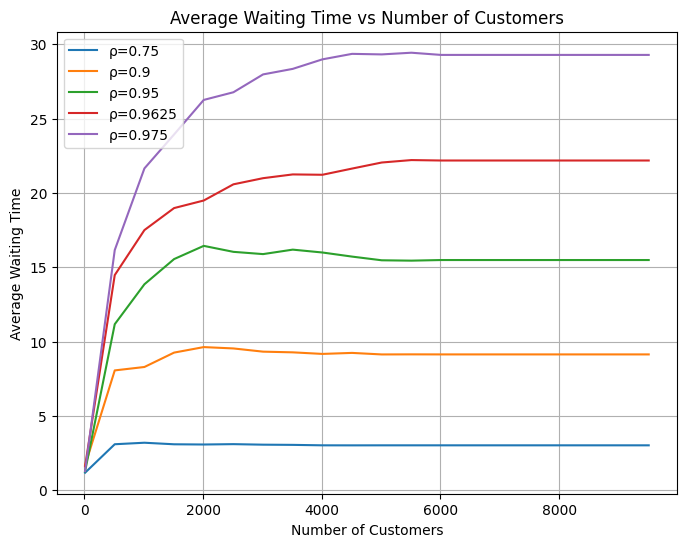

In [44]:
# Parameters
load_factors = [0.75, 0.90, 0.95, 0.9625, 0.975]
servers_count = 1
service_rate = 1.0
simulation_time = 6000
runs_per_config = 50

# Run simulations
results_df_mm1 = run_simulations(
    load_factors, runs_per_config, servers_count, service_rate, simulation_time
)

# Save the results to a CSV
results_df_mm1.to_csv("sim_mm1.csv", index=False)

# Plot the results
plot_simulations(results_df_mm1, load_factors)

### M/M/2

Running simulations for different load factors: 100%|██████████| 5/5 [00:52<00:00, 10.42s/it]


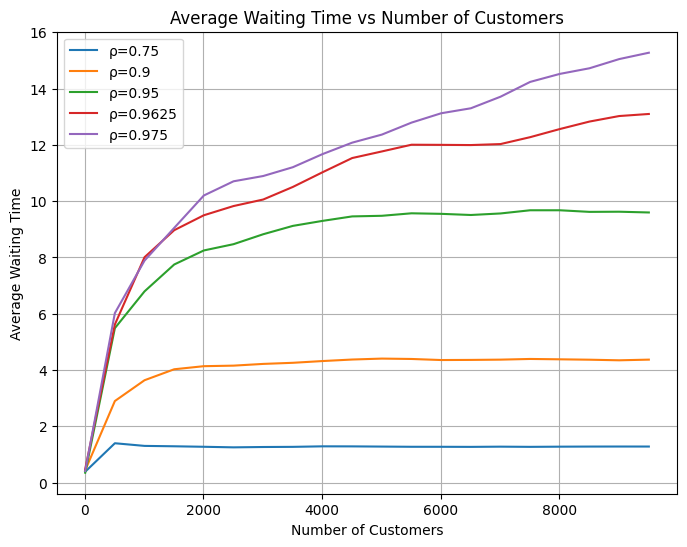

In [45]:
# Adjust server count to 2
servers_count = 2

# Run simulations
results_df_mm2 = run_simulations(
    load_factors, runs_per_config, servers_count, service_rate, simulation_time
)

# Save the results to a CSV
results_df_mm2.to_csv("sim_mm2.csv", index=False)

# Plot the results
plot_simulations(results_df_mm2, load_factors)

### M/M/4

Running simulations for different load factors: 100%|██████████| 5/5 [01:37<00:00, 19.43s/it]


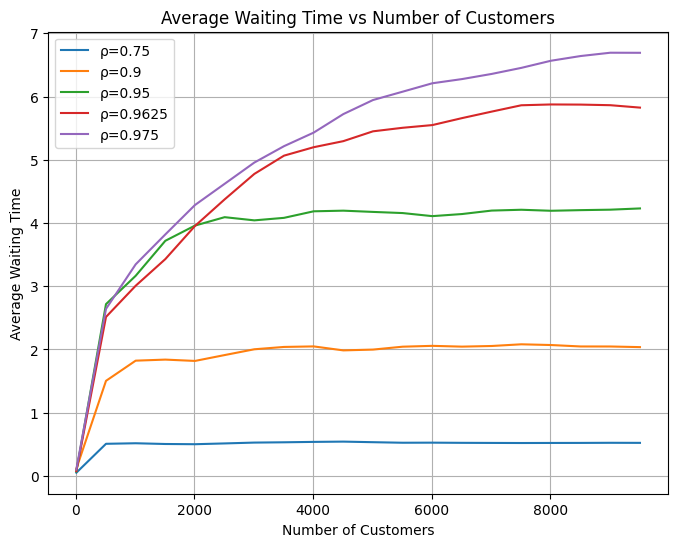

In [46]:
# Adjust server count to 4
servers_count = 4

# Run simulations
results_df_mm4 = run_simulations(
    load_factors, runs_per_config, servers_count, service_rate, simulation_time
)

# Save the results to a CSV
results_df_mm4.to_csv("sim_mm4.csv", index=False)

# Plot the results
plot_simulations(results_df_mm4, load_factors)

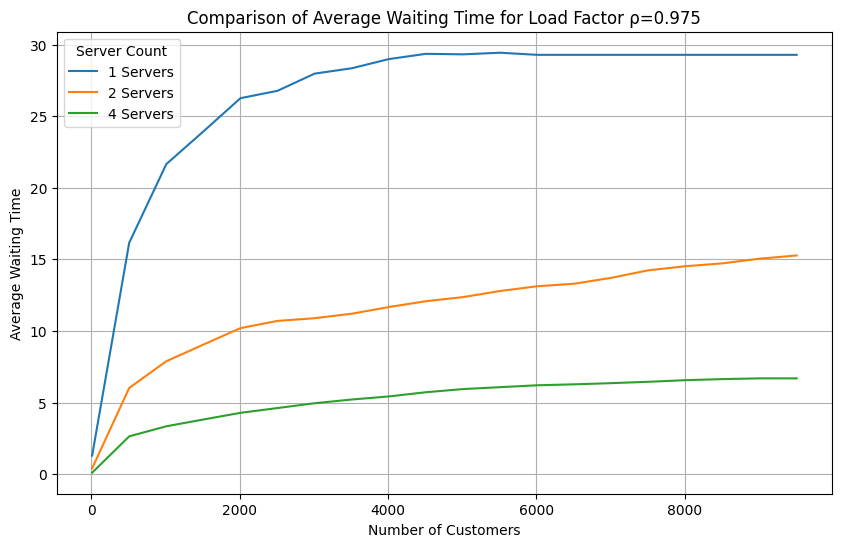

In [47]:
def plot_comparison_by_servers_for_load_factor(results_dfs: dict, server_counts: list, load_factor: float = load_factors[-1]) -> None:
    """Plot the comparison of average waiting time for a specific load factor across different server counts.

    Args:
        results_dfs: A dictionary where keys are server counts and values are pandas DataFrames
                     containing simulation results.
        load_factor: The specific load factor (ρ) to compare (e.g., 0.975).
        server_counts: A list of server counts to include in the plot (e.g., [1, 2, 4]).

    Returns:
        None. Displays a line plot.
    """
    plt.figure(figsize=(10, 6))
    
    for servers in server_counts:
        results_df = results_dfs[servers]
        # Filter the DataFrame for the specific load factor
        subset = results_df[results_df["Load Factor"] == load_factor]
        # Group by 'Customers' and calculate the mean wait time
        avg_waits = subset.groupby("Customers")["Mean Wait Time"].mean()
        # Plot the average waiting times
        plt.plot(avg_waits.index, avg_waits.values, label=f"{servers} Servers")
    
    plt.title(f"Comparison of Average Waiting Time for Load Factor ρ={load_factor}")
    plt.xlabel("Number of Customers")
    plt.ylabel("Average Waiting Time")
    plt.legend(title="Server Count")
    plt.grid(True)
    plt.show()


results_dfs = {
    1: results_df_mm1,
    2: results_df_mm2,
    4: results_df_mm4
}

# Call the plotting function for the highest load factor (0.975)
plot_comparison_by_servers_for_load_factor(
    results_dfs=results_dfs,
    server_counts=[1, 2, 4]  # List of server counts to compare
)

### Ayman: I though it was a good idea if we prepare additional data. Not sure if this works (e.g. did I do queuelength or length in system ,so please take time to check), but average length for M/M/1 FIFO: $L_q = \rho^2/(1-\rho) \approx 18$

Total customers processed across 200 runs: 3800905


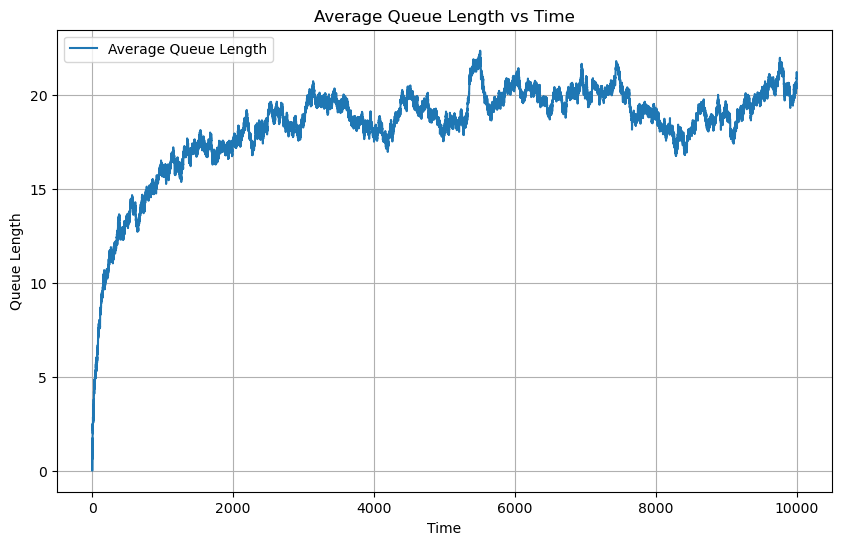

In [49]:
import simpy
import random
import matplotlib.pyplot as plt
from typing import List, Tuple, Generator, Callable

def interval_generator_markov(arrival_rate: float) -> float:
    """Generate a random number from an exponential distribution for interarrival times."""
    return random.expovariate(arrival_rate)

def service_time_generator_markov(service_rate: float) -> float:
    """Generate a random number from an exponential distribution for service times."""
    return random.expovariate(service_rate)

def client_process(
    env: simpy.Environment,
    resources: simpy.Resource,
    service_rate: float,
    queue_lengths: List[Tuple[float, int]],
) -> Generator[simpy.events.Event, None, None]:
    """Simulates a single client's process through the queue system."""
    arrival_time = env.now
    with resources.request() as request:
        queue_lengths.append((env.now, len(resources.queue) + 1))  # Record queue length
        yield request  # Wait for resource availability
        queue_lengths.append((env.now, len(resources.queue)))  # Update queue length
        yield env.timeout(service_time_generator_markov(service_rate))  # Simulate service time

def request_spawner(
    env: simpy.Environment,
    resources: simpy.Resource,
    arrival_rate: float,
    service_rate: float,
    queue_lengths: List[Tuple[float, int]],
    client_process: Callable[[simpy.Environment, simpy.Resource, float, List[Tuple[float, int]]], Generator[simpy.events.Event, None, None]]
) -> Generator[simpy.events.Event, None, None]:
    """Continuously spawns client processes based on interarrival times."""
    while True:
        yield env.timeout(interval_generator_markov(arrival_rate))
        env.process(client_process(env, resources, service_rate, queue_lengths))

def simulate_queue_network(
    num_servers: int, arrival_rate: float, service_rate: float, sim_time: float
) -> Tuple[List[Tuple[float, int]], int]:
    """Simulates a queueing network and tracks queue lengths and total customers."""
    load_factor = arrival_rate / (num_servers * service_rate)
    if load_factor >= 1:
        raise ValueError("Load factor (ρ) must be less than 1 for a stable system.")

    env = simpy.Environment()
    resources = simpy.Resource(env, capacity=num_servers)
    queue_lengths: List[Tuple[float, int]] = []  # Queue lengths over time
    customer_count = 0  # Track the total number of customers

    def wrapped_client_process(*args, **kwargs):
        nonlocal customer_count
        customer_count += 1
        return client_process(*args, **kwargs)

    env.process(
        request_spawner(
            env, resources, arrival_rate, service_rate, queue_lengths, wrapped_client_process
        )
    )
    env.run(until=sim_time)
    return queue_lengths, customer_count

def run_simulations_with_averaging(
    num_servers: int,
    arrival_rate: float,
    service_rate: float,
    sim_time: float,
    runs_per_config: int,
) -> Tuple[List[Tuple[float, float]], int]:
    """Runs multiple simulations and averages queue lengths over time."""
    all_runs = []

    for _ in range(runs_per_config):
        queue_lengths, customer_count = simulate_queue_network(num_servers, arrival_rate, service_rate, sim_time)
        all_runs.append(queue_lengths)

    # Aggregate queue lengths by averaging over runs
    times = [length[0] for length in all_runs[0]]  # Use the first run's times
    avg_lengths = []
    for i in range(len(times)):
        lengths_at_time = [run[i][1] for run in all_runs if i < len(run)]  # Gather lengths at the same time
        avg_lengths.append((times[i], sum(lengths_at_time) / len(lengths_at_time)))

    # Total customers processed across all runs
    total_customers = sum(len(run) for run in all_runs)
    return avg_lengths, total_customers

def plot_queue_length(queue_lengths: List[Tuple[float, float]]) -> None:
    """Plots the average queue length vs. time."""
    times, lengths = zip(*queue_lengths)
    plt.figure(figsize=(10, 6))
    plt.plot(times, lengths, label="Average Queue Length")
    plt.title("Average Queue Length vs Time")
    plt.xlabel("Time")
    plt.ylabel("Queue Length")
    plt.legend()
    plt.grid(True)
    plt.show()

# Simulation Parameters
load_factor = 0.95
servers_count = 1
service_rate = 1.0
arrival_rate = load_factor * servers_count * service_rate
simulation_time = 10000
runs_per_config = 200

# Run simulations with averaging
avg_queue_lengths, total_customers = run_simulations_with_averaging(
    servers_count, arrival_rate, service_rate, simulation_time, runs_per_config
)

# Print total customers processed
print(f"Total customers processed across {runs_per_config} runs: {total_customers}")

# Plot the average queue length vs time
plot_queue_length(avg_queue_lengths)

### Exercise 2: M/M/1 statistical analysis by Rohith. Ayman: we should discuss statistical aanalysis together so this can be left.

In [ ]:
def run_single_simulation(
    servers_count: int,
    arrival_rate: float,
    service_rate: float,
    simulation_time: int,
    runs: int,
    short_job_priority: bool = False,
) -> float:
    """Run a single simulation with a set configuration multiple times to compute the average waiting time.

    This function is executed for M/M/n FIFO by default.

    Args:
        servers_count: Number of servers in the system (n).
        arrival_rate: The arrival rate of the system (λ).
        service_rate: The service rate or capacity of each server (μ).
        simulation_time: Total simulation time.
        runs: Number of iterations to run for statistical significance.
        short_job_priority: Scheduling type for queue network. SJP if True, FIFO else.

    Returns:
        Tuple containing:
        - Mean waiting time across all runs.
        - Standard deviation of waiting times across all runs.
    """
    wait_times = []
    for _ in tqdm(range(runs), desc=f"Running for n={servers_count}, λ={arrival_rate}"):
        recorded_waits = simulate_queue_network(
            servers_count,
            arrival_rate,
            service_rate,
            simulation_time,
            short_job_priority=short_job_priority,
        )
        wait_times.append(np.mean(recorded_waits))

    return np.mean(wait_times), np.std(wait_times)


# Override config parameters
load_factor = 0.975
simulation_time = 60000
runs = 100
server_configs = [1, 2, 4]

# Run simulations for each server configuration
results = {}
for servers in server_configs:
    # Calculate arrival rate (λ = ρ * n * μ)
    arrival_rate = load_factor * servers * service_rate
    mean_wait, std_wait = run_single_simulation(
        servers, arrival_rate, service_rate, simulation_time, runs
    )
    results[servers] = {"Mean Wait Time": mean_wait, "Std Dev": std_wait}

# Print results
print(f"\nSimulation Results (ρ={load_factor}):")
for servers, statistics in results.items():
    print(
        f"n={servers}: "
        f"Mean Wait Time = {statistics['Mean Wait Time']:.4f}, "
        f"Std Dev = {statistics['Std Dev']:.4f}"
    )

# Compare n=2,4 to n=1
print("\nInsights:")
for servers in server_configs[1:]:
    reduction = (
        (results[1]["Mean Wait Time"] - results[servers]["Mean Wait Time"])
        / results[1]["Mean Wait Time"]
        * 100
    )
    print(
        f"Adding more servers (n={servers}): "
        f"Wait time reduced by {reduction:.2f}% compared to n=1."
    )

Running for n=4, λ=3.9: 100%|██████████| 20/20 [00:08<00:00,  2.45it/s]


Simulation Results (ρ=0.975):
n=1: Mean Wait Time = 23.6645, Std Dev = 12.5408
n=2: Mean Wait Time = 14.4395, Std Dev = 5.3806
n=4: Mean Wait Time = 8.4944, Std Dev = 2.2478

Insights:
Adding more servers (n=2): Wait time reduced by 38.98% compared to n=1.
Adding more servers (n=4): Wait time reduced by 64.10% compared to n=1.


### Exercise 3:

In [30]:
arrival_rate = 0.975

mean_wait, std_wait = run_single_simulation(
    1, arrival_rate, service_rate, simulation_time, runs, short_job_priority=True
)

print("\nSimulation of Priority Results (ρ=0.975):")
print(f"n={servers}: " f"Mean Wait Time = {mean_wait:.4f}, " f"Std Dev = {std_wait:.4f}")

Running for n=1, λ=0.975: 100%|██████████| 20/20 [00:02<00:00,  7.42it/s]


Simulation of Priority Results (ρ=0.975):
n=4: Mean Wait Time = 28.0859, Std Dev = 17.5004


### Exercise 4: Ayman : please check whether results make sense

Running simulations for different load factors: 100%|██████████| 5/5 [00:27<00:00,  5.58s/it]


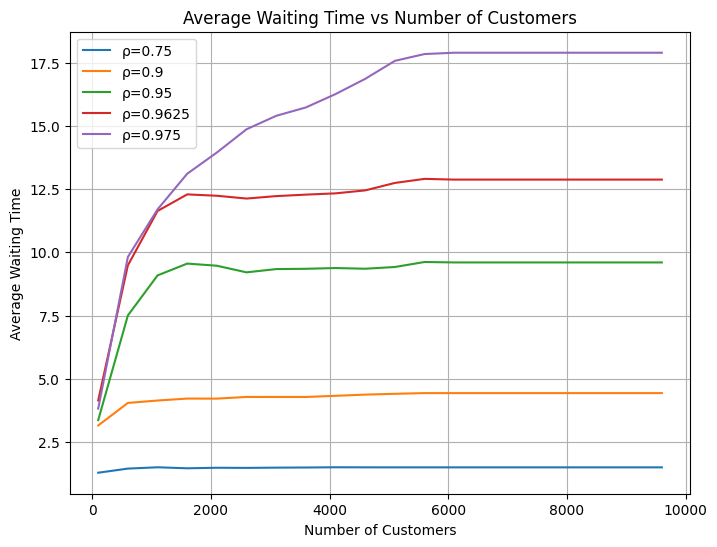

In [32]:
# Parameters
load_factors = [0.75, 0.90, 0.95, 0.9625, 0.975]
servers_count = 1
service_rate = 1.0
simulation_time = 6000
runs_per_config = 50

def service_time_generator_deterministic(service_rate: float) -> float:
    """Generate deterministic service times."""
    return 1 / service_rate  # Deterministic service time is 1/μ


def deterministic_client_process(
    env: simpy.Environment,
    resources: simpy.Resource,
    service_rate: float,
    wait_records: List[float],
) -> Generator[simpy.events.Event, None, None]:
    """Simulates a single client's process through the queue system, including waiting and service times.

    Args:
        env: The SimPy environment managing simulation time.
        resources: The shared resource (e.g., servers) being accessed by the client.
        service_rate: The service rate or capacity of each server (μ).
        wait_records: A list to record the wait times of clients.

    Yields:
        Events representing the client's waiting and service times.
    """
    arrival_time = env.now
    with resources.request() as request:
        yield request  # Wait for resource availability
        wait_time = env.now - arrival_time
        wait_records.append(wait_time)  # Record the wait time
        yield env.timeout(service_time_generator_deterministic(service_rate))  # Simulate deterministic service time

# Run simulations
results_df_md1 = run_simulations(
    load_factors, runs_per_config, servers_count, service_rate, simulation_time, client_process=deterministic_client_process
)

# Save the results to a CSV
results_df_md1.to_csv("sim_md1.csv", index=False)

# Plot the results
plot_simulations(results_df_md1, load_factors)

Running simulations for different load factors: 100%|██████████| 4/4 [00:42<00:00, 10.54s/it]


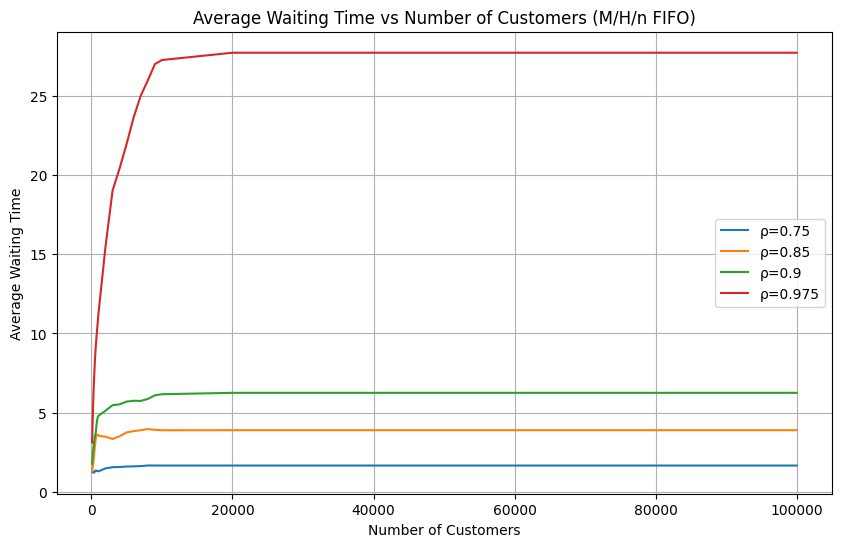

In [34]:
import simpy
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List, Tuple, Generator


def interval_generator_markov(arrival_rate: float) -> float:
    """Generate interarrival times from an exponential distribution."""
    return random.expovariate(arrival_rate)


def service_time_generator_hyperexponential(p1: float, mean1: float, mean2: float) -> float:
    """Generate service times from a hyperexponential distribution.

    Args:
        p1: The probability of selecting the first distribution.
        mean1: Mean of the first exponential distribution (1/λ1).
        mean2: Mean of the second exponential distribution (1/λ2).

    Returns:
        A service time drawn from the hyperexponential distribution.
    """
    if random.random() < p1:  # Choose the first distribution
        return random.expovariate(1 / mean1)
    else:  # Choose the second distribution
        return random.expovariate(1 / mean2)


def client_process(
    env: simpy.Environment,
    resources: simpy.Resource,
    p1: float,
    mean1: float,
    mean2: float,
    wait_records: List[float],
) -> Generator[simpy.events.Event, None, None]:
    """Simulates a single client's process through the queue system with hyperexponential service times.

    Args:
        env: The SimPy environment managing simulation time.
        resources: The shared resource (e.g., servers) being accessed by the client.
        p1: The probability of selecting the first distribution for service times.
        mean1: Mean of the first exponential distribution.
        mean2: Mean of the second exponential distribution.
        wait_records: A list to record the wait times of clients.

    Yields:
        Events representing the client's waiting and service times.
    """
    arrival_time = env.now
    with resources.request() as request:
        yield request  # Wait for resource availability
        wait_time = env.now - arrival_time
        wait_records.append(wait_time)  # Record the wait time
        service_time = service_time_generator_hyperexponential(p1, mean1, mean2)
        yield env.timeout(service_time)  # Simulate hyperexponential service time


def request_spawner(
    env: simpy.Environment,
    resources: simpy.Resource,
    arrival_rate: float,
    p1: float,
    mean1: float,
    mean2: float,
    wait_records: List[float],
) -> Generator[simpy.events.Event, None, None]:
    """Continuously spawns client processes with hyperexponential service times."""
    while True:
        yield env.timeout(interval_generator_markov(arrival_rate))  # Interarrival time
        env.process(client_process(env, resources, p1, mean1, mean2, wait_records))


def simulate_queue_network(
    num_servers: int,
    arrival_rate: float,
    p1: float,
    mean1: float,
    mean2: float,
    sim_time: float,
) -> List[float]:
    """Simulates an M/H/n FIFO queueing network with hyperexponential service times.

    Args:
        num_servers: Number of servers in the system (n).
        arrival_rate: The arrival rate of the system (λ).
        p1: The probability of selecting the first distribution for service times.
        mean1: Mean of the first exponential distribution.
        mean2: Mean of the second exponential distribution.
        sim_time: Total simulation time.

    Returns:
        A list of recorded wait times for all clients during the simulation.
    """
    avg_service_time = p1 * mean1 + (1 - p1) * mean2
    load_factor = arrival_rate * avg_service_time / num_servers
    if load_factor >= 1:
        raise ValueError("Load factor (ρ) must be less than 1 for a stable system.")

    env = simpy.Environment()
    resources = simpy.Resource(env, capacity=num_servers)
    wait_records: List[float] = []  # List to store wait times
    env.process(request_spawner(env, resources, arrival_rate, p1, mean1, mean2, wait_records))
    env.run(until=sim_time)  # Run the simulation
    return wait_records


def run_simulations(
    load_factors: List[float],
    runs_per_config: int,
    servers_count: int,
    p1: float,
    mean1: float,
    mean2: float,
    simulation_time: int,
) -> pd.DataFrame:
    """Run multiple simulations for a queueing network with hyperexponential service times."""
    results_dict = {
        "Load Factor": [],
        "Servers": [],
        "Customers": [],
        "Iteration": [],
        "Mean Wait Time": [],
    }

    for load_factor in tqdm(load_factors, desc="Running simulations for different load factors"):
        avg_service_time = p1 * mean1 + (1 - p1) * mean2
        arrival_rate = load_factor * servers_count / avg_service_time
        for iteration in tqdm(
            range(runs_per_config), leave=False, desc=f"Simulating for ρ={load_factor:.2f}"
        ):
            recorded_waits = simulate_queue_network(
                servers_count, arrival_rate, p1, mean1, mean2, simulation_time
            )
            customer_counts = np.concatenate(
                (
                    np.arange(100, 1000, 100),
                    np.arange(1000, 10000, 1000),
                    np.arange(10000, 100001, 10000),
                )
            )
            for count in customer_counts:
                average_wait = np.mean(recorded_waits[:count])
                results_dict["Load Factor"].append(load_factor)
                results_dict["Servers"].append(servers_count)
                results_dict["Customers"].append(count)
                results_dict["Iteration"].append(iteration)
                results_dict["Mean Wait Time"].append(average_wait)

    results_df = pd.DataFrame(results_dict)
    return results_df


def plot_simulations(results_df: pd.DataFrame, load_factors: List[float]) -> None:
    """Plot the average waiting time as a function of the number of customers."""
    plt.figure(figsize=(10, 6))
    for load_factor in load_factors:
        subset = results_df[results_df["Load Factor"] == load_factor]
        avg_waits = subset.groupby("Customers")["Mean Wait Time"].mean()
        plt.plot(avg_waits.index, avg_waits.values, label=f"ρ={load_factor}")
    # plt.hlines(6.8, 0, 100000)
    plt.title("Average Waiting Time vs Number of Customers (M/H/n FIFO)")
    plt.xlabel("Number of Customers")
    plt.ylabel("Average Waiting Time")
    plt.legend()
    plt.grid(True)
    plt.show()


# Parameters
load_factors = [0.75, 0.85, 0.9, 0.975]
servers_count = 4
p1 = 0.75
mean1 = 1.0
mean2 = 5.0
simulation_time = 6000
runs_per_config = 50

# Run simulations
results_df = run_simulations(load_factors, runs_per_config, servers_count, p1, mean1, mean2, simulation_time)

# Save the results to a CSV
results_df.to_csv("mhn_fifo_simulations_output.csv", index=False)

# Plot the results
plot_simulations(results_df, load_factors)